In [12]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pdb

from helpers import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [31]:
def readLang(filename, lang, size):
    print("Reading lines...")

    # Read the file and split into lines
    with open(filename, encoding='utf-8') as file:
        lines = [next(file).strip() for x in range(size)]
        
    print(lines[0])

    # Split every line into pairs and normalize
    pairs = [normalizeString(l) for l in lines]
    print(pairs[0])

    lang = Lang(lang)

    return lang, pairs

In [50]:
SOS_token = 0
EOS_token = 1

def prepareData(filename, lang, size):
    lang, pairs = readLang(filename, lang, size)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    print(pairs[0])
    for pair in pairs:
        lang.addSentence(pair)
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs

eng_lang, eng_sents = prepareData('iwslt-vi-en-processed/train.en', 'eng', size=50000)
vi_lang, vi_sents = prepareData('iwslt-vi-en-processed/train.vi', 'vi', size=50000)

Reading lines...
Rachel Pike: The science behind a climate headline
rachel pike the science behind a climate headline
Read 50000 sentence pairs
Counting words...
rachel pike the science behind a climate headline
Counted words:
eng 26516
Reading lines...
Khoa học đằng sau một tiêu đề về khí hậu
khoa hoc ang sau mot tieu e ve khi hau
Read 50000 sentence pairs
Counting words...
khoa hoc ang sau mot tieu e ve khi hau
Counted words:
vi 7521


In [53]:
print(random.choice(eng_sents))
print(random.choice(vi_sents))

people like josh and steve are continuing to layer information upon information real time information tweet it and text it onto these maps for all to use .
ao thuat gia choi ua voi lua va thep bat chap con thinh no cua luoi cua dam tay khong bat an hoac thu tron thoat trong uong to ke toc .


### The Encoder

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        # output and hidden are the same vectors
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training
#### Preparing Training Data

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

In [22]:
teacher_forcing_ratio = 0.5


# example of input_tensor: [2, 43, 23, 9, 19, 4]. Indexed on our vocabulary. 
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # iterate GRU over words --> final hidden state is representation of source sentence. 
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

0m 4s (- 7m 29s) (100 1%) 4.2950
0m 8s (- 7m 11s) (200 2%) 3.5779
0m 13s (- 7m 9s) (300 3%) 3.5048
0m 18s (- 7m 14s) (400 4%) 3.5253
0m 22s (- 7m 2s) (500 5%) 3.3844
0m 26s (- 6m 56s) (600 6%) 3.4836
0m 30s (- 6m 48s) (700 7%) 3.3021
0m 35s (- 6m 44s) (800 8%) 3.4473
0m 39s (- 6m 39s) (900 9%) 3.2549
0m 43s (- 6m 31s) (1000 10%) 3.3959
0m 47s (- 6m 25s) (1100 11%) 3.2188
0m 51s (- 6m 20s) (1200 12%) 3.2056
0m 56s (- 6m 14s) (1300 13%) 3.1289
1m 0s (- 6m 10s) (1400 14%) 3.1543
1m 4s (- 6m 6s) (1500 15%) 3.2194
1m 9s (- 6m 2s) (1600 16%) 3.2385
1m 13s (- 5m 58s) (1700 17%) 3.0890
1m 17s (- 5m 54s) (1800 18%) 2.9515
1m 22s (- 5m 50s) (1900 19%) 2.9906
1m 26s (- 5m 45s) (2000 20%) 2.8720
1m 30s (- 5m 40s) (2100 21%) 2.8863
1m 34s (- 5m 36s) (2200 22%) 2.9280
1m 39s (- 5m 31s) (2300 23%) 2.6736
1m 43s (- 5m 26s) (2400 24%) 2.8789
1m 47s (- 5m 23s) (2500 25%) 2.9839
1m 52s (- 5m 19s) (2600 26%) 2.6225
1m 57s (- 5m 16s) (2700 27%) 2.8273
2m 1s (- 5m 12s) (2800 28%) 2.8808
2m 6s (- 5m 10s) (29

<Figure size 432x288 with 0 Axes>

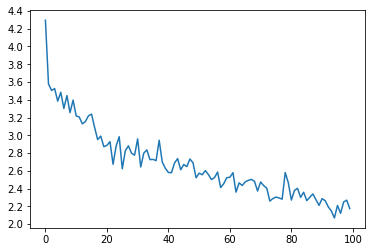

In [25]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(output_lang.n_words, hidden_size).to(device)

num_iters = 10000
trainIters(encoder1, decoder1, num_iters, print_every=100)